In [1]:
import sys
sys.path.append('..')

from config import *
from src.db.tools import *

import pandas as pd
import numpy as np

In [48]:
data_dict = reading_csv(SaveConfig.OUT_DIR)

machine_table = data_dict['machine_table']
truck_table = data_dict['truck_table']
path_table = data_dict['path_table']

print(f"table names: {data_dict.keys()}")

table names: dict_keys(['machine_table', 'path_table', 'pipeline_table', 'truck_table'])


## checking path

In [49]:
temp = machine_table.groupby('small_id')['equipment_id'].apply(lambda x: len(x.unique()))

In [50]:
temp.value_counts()

5     76411
6     57460
4     28771
12    19749
11    17044
9     11198
1     10791
13     9224
10     7223
7      2116
8      1971
15     1336
14      942
16      290
17       13
Name: equipment_id, dtype: int64

In [51]:
temp.value_counts().sum()

244539

## checking m j wait time

In [7]:
targe_small = machine_table[machine_table.equipment_id.str.contains('j')].small_id.unique()

target_table = machine_table[machine_table.small_id.isin(targe_small)]

ind_m = target_table.equipment_id.str.startswith('m')
ind_j = target_table.equipment_id.str.startswith('j')

ind_wait = target_table.action == 'wait'
ind_end = target_table.action == 'end'
ind_start = target_table.action == 'start'

mj_table = target_table[(ind_m & ind_end) | (ind_j & ind_start)]

result_diff = \
    mj_table.set_index(['equipment_id', 'small_id', 'action'])['time_stamp'].diff().reset_index()

mj_table.set_index(['equipment_id', 'small_id', 'action'])\
    .groupby(level=1)['time_stamp'].apply(lambda x: x.diff()).reset_index()

result = result_diff[result_diff.action == 'start']

In [8]:
result.time_stamp.replace(0, np.nan).describe()

count      780.000000
mean      7191.759731
std       3453.031002
min        141.630000
25%       5916.703750
50%       7622.665000
75%       8184.635000
max      15448.925000
Name: time_stamp, dtype: float64

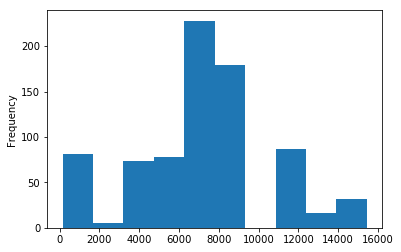

In [9]:
%matplotlib inline
result.time_stamp.plot(kind='hist')

## checking r/a last work time

In [10]:
r_a_table = machine_table[machine_table.equipment_id.str.get(0).isin(['r', 'a'])]

r_a_table_last = r_a_table.groupby('equipment_id')['real_time_stamp'].max().reset_index()

unload_setting = get_unload_setting()

r_a_table_last['real_time_stamp'] = pd.to_datetime(r_a_table_last['real_time_stamp'])

r_a_table_last_res = \
    r_a_table_last\
        .groupby([r_a_table_last['equipment_id']\
                  .apply(lambda x: tuple(unload_setting[x])), 'equipment_id'])\
            ['real_time_stamp'].apply(lambda x: list(x)[0])

r_a_table_last_res = r_a_table_last_res.rename_axis(['unload_type', 'equipment_id']).reset_index()

cols = ['unload_type', 'real_time_stamp']

r_a_table_last_res_sort = \
    r_a_table_last_res.sort_values(cols).set_index(['unload_type', 'equipment_id'])

2017-08-20 17:00:17,993 - django - INFO - Reading Redis i_unload_setting


## analysis truck

In [11]:
truck_table_end = truck_table[truck_table.action == 'end']

truck_table_end_store_count = \
    truck_table_end.groupby(
        [truck_table_end['equipment_id'].apply(lambda x: tuple(unload_setting[x])), 'equipment_id'])\
            ['store_size'].sum()

truck_table_end_store_count = \
    truck_table_end_store_count.rename_axis(['unload_type', 'equipment_id']).reset_index()

cols = ['unload_type', 'store_size']
truck_table_end_store_count_sort = \
    truck_table_end_store_count.sort_values(cols).set_index(['unload_type', 'equipment_id'])

truck_unload_table = \
    pd.concat([truck_table_end_store_count_sort, r_a_table_last_res_sort], axis=1)

truck_unload_table.reset_index(inplace=True)

In [12]:
truck_unload_table.sort_values(['unload_type', 'store_size']).set_index(['unload_type', 'equipment_id'])

store_size         real_time_stamp
unload_type equipment_id                                    
(AA, AL)    a2_6                  20 2017-07-26 01:56:29.000
            a2_7                  20 2017-07-26 01:56:32.000
            a2_8                  20 2017-07-26 01:56:37.000
            a2_9                  20 2017-07-26 01:56:45.000
            a1_1                  21 2017-07-26 01:32:58.000
            a1_10                 21 2017-07-26 01:57:12.000
            a1_11                 21 2017-07-26 01:57:26.000
            a1_12                 21 2017-07-26 01:57:28.000
            a1_2                  21 2017-07-26 01:57:40.000
            a1_3                  21 2017-07-26 01:57:45.000
            a1_4                  21 2017-07-26 01:57:47.000
            a1_5                  21 2017-07-26 01:57:51.000
            a1_6                  21 2017-07-26 01:58:16.000
            a1_7                  21 2017-07-26 01:58:16.000
            a1_8                  21 2017-07-26 01:58:29.000
            a1_9                  21 2017-07-26 01:58:48.000
            a2_1                  21 2017-07-26 01:59:20.000
            a2_10                 21 2017-07-26 01:59:35.000
            a2_11                 21 2017-07-26 01:59:38.000
            a2_12                 21 2017-07-26 01:59:39.000
            a2_2                  21 2017-07-26 01:59:41.000
            a2_3                  21 2017-07-26 01:59:45.000
            a2_4                  21 2017-07-26 01:59:45.000
            a2_5                  21 2017-07-26 01:59:49.000
(LL,)       r1_2                   4 2017-07-26 00:07:24.680
            r2_3                   6 2017-07-26 00:28:01.360
            r1_4                   9 2017-07-26 00:11:32.680
            r1_1                  11 2017-07-25 23:36:51.360
            r2_2                  14 2017-07-26 00:14:03.040
            r2_1                  15 2017-07-26 01:26:27.680
            r2_4                  15 2017-07-26 01:39:58.680
            r1_3                  17 2017-07-26 00:31:29.680
(LL, LA)    r5_4                   5 2017-07-26 01:04:53.130
            r3_4                   7 2017-07-26 01:38:03.130
            r4_7                   8 2017-07-26 00:49:34.260
            r3_3                   9 2017-07-26 01:35:51.130
            r3_10                 10 2017-07-26 01:21:18.260
            r5_2                  10 2017-07-26 01:02:44.260
            r3_6                  11 2017-07-26 01:49:06.130
            r4_4                  11 2017-07-26 00:22:17.130
            r4_6                  11 2017-07-26 00:28:38.260
            r3_8                  12 2017-07-26 01:52:11.130
            r4_10                 12 2017-07-26 00:12:20.260
            r5_1                  12 2017-07-26 01:02:33.390
            r4_3                  16 2017-07-26 00:16:49.260
            r5_3                  18 2017-07-26 01:03:03.650
            r3_5                  20 2017-07-26 01:44:26.390
            r3_1                  21 2017-07-25 21:00:03.130
            r3_7                  21 2017-07-26 01:51:26.260
            r3_2                  22 2017-07-26 01:35:15.260
            r4_8                  23 2017-07-26 01:02:11.260
            r4_1                  25 2017-07-26 01:57:57.260
            r4_2                  25 2017-07-25 21:48:42.130
            r4_9                  29 2017-07-26 01:02:37.040
            r4_5                  34 2017-07-26 00:25:21.260
            r3_9                  37 2017-07-26 01:53:20.130

## j table

需要过安检的量

In [13]:
truck_table_end[truck_table_end.truck_type == 'LA'].store_size.sum()

382

In [14]:
j_table = machine_table[machine_table.equipment_id.str.contains('j')]

In [15]:
j41_table = machine_table[machine_table.equipment_id.str.contains('j41')]

实际过安检的量

In [16]:
len(j_table.parcel_id.unique())

509

过 j41 安检的量

In [17]:
len(j41_table.parcel_id.unique())

443

每个安检机处理的量

In [18]:
j_process_count = j_table.groupby('equipment_id')['parcel_id'].apply(lambda x: len(set(x)))

In [19]:
j_process_count

equipment_id
j10_1      2
j11_1      3
j12_1      2
j13_1      3
j14_1      2
j15_1      3
j16_1      2
j17_1      3
j18_1      2
j19_1      2
j1_1       2
j20_1      2
j21_1      2
j22_1      2
j23_1      2
j24_1      1
j25_1      1
j26_1      2
j27_1      1
j28_1      3
j29_1      1
j2_1       2
j30_1      2
j32_1      2
j34_1      3
j36_1      2
j38_1      2
j3_1       1
j40_1      2
j41_1    443
j4_1       1
j5_1       1
j6_1       1
j7_1       1
j8_1       1
j9_1       2
Name: parcel_id, dtype: int64

# random

In [52]:
import random

small_id_store = machine_table.small_id.unique()

In [53]:
g = machine_table.groupby('small_id')

In [55]:
small_id = random.choice(small_id_store)
g.get_group(small_id)

,equipment_id,parcel_id,small_id,parcel_type,time_stamp,action,real_time_stamp,run_time
130039,r5_4,230481,230481,parcel,16548.000,wait,2017-07-26 01:35:48.000,2017-08-20 17:33:25.283401
130040,r5_4,230481,230481,parcel,18216.290,start,2017-07-26 02:03:36.290,2017-08-20 17:33:25.283401
130041,r5_4,230481,230481,parcel,18219.420,end,2017-07-26 02:03:39.420,2017-08-20 17:33:25.283401
130042,m3_2,230481,230481,parcel,18277.330,wait,2017-07-26 02:04:37.330,2017-08-20 17:33:25.283401
130043,m3_2,230481,230481,parcel,29058.910,start,2017-07-26 05:04:18.910,2017-08-20 17:33:25.283401
130044,m3_2,230481,230481,parcel,29061.910,end,2017-07-26 05:04:21.910,2017-08-20 17:33:25.283401
130045,j27_1,230481,230481,parcel,29235.950,wait,2017-07-26 05:07:15.950,2017-08-20 17:33:25.283401
130046,j27_1,230481,230481,parcel,29289.970,start,2017-07-26 05:08:09.970,2017-08-20 17:33:25.283401
130047,j27_1,230481,230481,parcel,29294.735,end,2017-07-26 05:08:14.735,2017-08-20 17:33:25.283401
130048,i17_2,230481,230481,parcel,29438.645,wait,2017-07-26 05:10:38.645,2017-08-20 17:33:25.283401


平均处理时间（总路径）

In [54]:
table_diff = g['time_stamp'].apply(lambda x: x.max() - x.min())

In [56]:
table_diff.describe()

count    244539.000000
mean      11549.189669
std        7414.936233
min           0.000000
25%        6323.897500
50%       10847.125000
75%       15366.185000
max       36738.200000
Name: time_stamp, dtype: float64

In [57]:
table_diff[table_diff > 30000]

small_id
194       30978.570
202       31089.455
204       31139.650
207       31303.170
208       31268.305
291       30734.415
330       35068.145
353       35951.070
578       34038.990
719       34158.115
767       30053.350
786       30152.835
792       31677.430
914       35613.120
922       30697.810
946       35596.610
978       32104.385
1844      30709.440
1899      30717.270
1900      30868.065
1905      30920.460
1908      30848.725
1910      31507.180
2012      31042.000
2217      31620.915
2277      31771.650
2284      31832.340
2519      32471.500
2556      32634.440
2559      32720.270
            ...    
736708    33845.635
736709    33845.635
736710    33883.755
736711    33845.635
736956    32154.060
737139    31679.180
737140    31831.600
737141    31679.180
737142    32357.315
737143    32398.635
737144    33664.295
737145    33134.700
737502    32074.435
737595    31679.180
737596    33882.795
737820    31920.575
737821    32087.080
737822    31679.180
737824    3

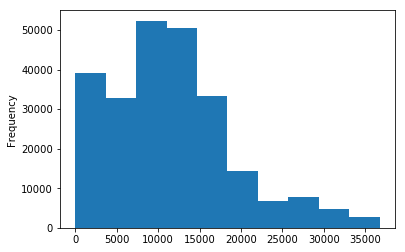

In [59]:
table_diff.plot(kind='hist')

In [58]:
g.get_group(767)

,equipment_id,parcel_id,small_id,parcel_type,time_stamp,action,real_time_stamp,run_time
1093958,r4_8,767,767,parcel,11372.000,wait,2017-07-26 00:09:32.000,2017-08-20 17:33:25.283401
1093959,r4_8,767,767,parcel,16830.200,start,2017-07-26 01:40:30.200,2017-08-20 17:33:25.283401
1093960,r4_8,767,767,parcel,16833.330,end,2017-07-26 01:40:33.330,2017-08-20 17:33:25.283401
1093961,m2_8,767,767,parcel,16891.240,wait,2017-07-26 01:41:31.240,2017-08-20 17:33:25.283401
1093962,m2_8,767,767,parcel,29247.910,start,2017-07-26 05:07:27.910,2017-08-20 17:33:25.283401
1093963,m2_8,767,767,parcel,29250.910,end,2017-07-26 05:07:30.910,2017-08-20 17:33:25.283401
1093964,j15_1,767,767,parcel,29563.040,wait,2017-07-26 05:12:43.040,2017-08-20 17:33:25.283401
1093965,j15_1,767,767,parcel,41144.845,start,2017-07-26 08:25:44.845,2017-08-20 17:33:25.283401
1093966,j15_1,767,767,parcel,41149.610,end,2017-07-26 08:25:49.610,2017-08-20 17:33:25.283401
1093967,i22_3,767,767,parcel,41290.440,wait,2017-07-26 08:28:10.440,2017-08-20 17:33:25.283401


## 安检机

In [60]:
security_dict = get_equipment_store_dict()

2017-08-20 18:33:31,049 - django - INFO - Reading mysql table i_queue_io
2017-08-20 18:33:32,641 - django - INFO - Redis write table i_queue_io succeed!


In [61]:
from collections import defaultdict

In [62]:
d = defaultdict(list)

In [63]:
for k,v in security_dict.items():
    d[v].append(k)

In [64]:
d

defaultdict(list,
            {'J_214': ['j10_1',
              'j12_1',
              'j14_1',
              'j16_1',
              'j18_1',
              'j20_1',
              'j22_1',
              'j24_1'],
             'J_215': ['j1_1',
              'j2_1',
              'j3_1',
              'j4_1',
              'j5_1',
              'j6_1',
              'j7_1',
              'j8_1'],
             'J_218': ['j26_1',
              'j28_1',
              'j30_1',
              'j32_1',
              'j34_1',
              'j36_1',
              'j38_1',
              'j40_1'],
             'J_219': ['j11_1',
              'j13_1',
              'j15_1',
              'j17_1',
              'j19_1',
              'j21_1',
              'j23_1',
              'j9_1'],
             'J_220': ['j25_1',
              'j27_1',
              'j29_1',
              'j31_1',
              'j33_1',
              'j35_1',
              'j37_1',
              'j39_1'],
             'U_1': [

In [65]:
get_equipment_process_time()['j15_1']

2017-08-20 18:33:42,420 - django - INFO - Reading mysql table i_equipment_io
2017-08-20 18:33:43,109 - django - INFO - Redis write table i_equipment_io succeed!


4.7649999999999997

In [35]:
table_resource_limit = get_resource_limit()

2017-08-20 17:00:45,138 - django - INFO - Reading Redis i_resource_limit
2017-08-20 17:00:45,144 - django - INFO - Reading Redis i_equipment_resource
2017-08-20 17:00:45,147 - django - INFO - Reading Redis i_equipment_io


In [36]:
table_resource_limit[table_resource_limit.resource_id.str.contains('j15_1')]

,resource_id,resource_name,resource_limit,capacity_per_resource,resource_on_number,resource_number,start_time,end_time,inserted_on,modified_on,process_time
36,man_j15_1,j15人力1,1.0,1.0,1.0,1.0,2017-07-25 21:00:00,2017-07-25 21:30:00,NaT,NaT,4.765


## 检查开关

In [66]:
machine_table[machine_table.equipment_id == 'a1_1']

,equipment_id,parcel_id,small_id,parcel_type,time_stamp,action,real_time_stamp,run_time


In [67]:
sorted(machine_table.equipment_id.unique())

['a1_10',
 'a1_4',
 'a1_7',
 'a1_9',
 'a2_11',
 'a2_12',
 'a2_3',
 'a2_6',
 'a2_9',
 'c10_10',
 'c10_100',
 'c10_101',
 'c10_102',
 'c10_103',
 'c10_104',
 'c10_12',
 'c10_13',
 'c10_15',
 'c10_16',
 'c10_17',
 'c10_18',
 'c10_19',
 'c10_20',
 'c10_21',
 'c10_22',
 'c10_23',
 'c10_24',
 'c10_25',
 'c10_26',
 'c10_27',
 'c10_28',
 'c10_29',
 'c10_3',
 'c10_30',
 'c10_31',
 'c10_32',
 'c10_33',
 'c10_34',
 'c10_35',
 'c10_36',
 'c10_38',
 'c10_39',
 'c10_4',
 'c10_40',
 'c10_41',
 'c10_42',
 'c10_43',
 'c10_44',
 'c10_45',
 'c10_46',
 'c10_47',
 'c10_48',
 'c10_5',
 'c10_50',
 'c10_51',
 'c10_52',
 'c10_53',
 'c10_54',
 'c10_55',
 'c10_56',
 'c10_57',
 'c10_58',
 'c10_59',
 'c10_6',
 'c10_60',
 'c10_61',
 'c10_62',
 'c10_63',
 'c10_64',
 'c10_65',
 'c10_66',
 'c10_67',
 'c10_68',
 'c10_69',
 'c10_7',
 'c10_70',
 'c10_71',
 'c10_72',
 'c10_73',
 'c10_74',
 'c10_75',
 'c10_76',
 'c10_77',
 'c10_79',
 'c10_8',
 'c10_80',
 'c10_81',
 'c10_83',
 'c10_84',
 'c10_85',
 'c10_86',
 'c10_87',
 'c1